# Building a Knowledge Graph

In [337]:
import pyspark as sp
import numpy as np
import string
import re

### Required for environment variable

In [2]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/local/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/local/bin/python3"

### Setup cluster

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Knowledge Graph Project") \
    .master("local[*]") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


###  Load dataset (100 documents, 20 keywords)

In [94]:
df_keywords = spark.read.csv("./mag_cs_keywords.csv",header=True)
df_arxiv = spark.read.json("./arxiv-metadata-oai-snapshot.json")

In [101]:
abstracts = df_arxiv.select("id","abstract")
keywords = df_keywords.select("normalizedName")

### Cleaning & Normalization

In [96]:
from pyspark.sql.functions import udf, col
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType

# remove non ASCII characters & lowercase
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c.lower() for c in data_str if 0 < ord(c) < 127)

    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [107]:
abstracts = abstracts.withColumn('normalized', strip_non_ascii_udf(abstracts['abstract']))
abstracts = abstracts.select("id","normalized")

1. Extract keywords in document
    - https://stackoverflow.com/questions/48869922/how-to-efficiently-check-if-a-list-of-words-is-contained-in-a-spark-dataframe
    - https://stackoverflow.com/questions/46410887/pyspark-string-matching-to-create-new-column

   
2. Build Co-occurence matrix
    - https://stackoverflow.com/questions/48551900/spark-generate-occurrence-matrix
   
   
3. Useful tutorials
   - https://spark.apache.org/docs/1.6.3/ml-features.html

In [108]:
abstracts.show()

+---------+--------------------+
|       id|          normalized|
+---------+--------------------+
|0704.0001|  a fully differe...|
|0704.0002|  we describe a n...|
|0704.0003|  the evolution o...|
|0704.0004|  we show that a ...|
|0704.0005|  in this paper w...|
|0704.0006|  we study the tw...|
|0704.0007|  a rather non-st...|
|0704.0008|  a general formu...|
|0704.0009|  we discuss the ...|
|0704.0010|  partial cubes a...|
|0704.0011|  in this paper w...|
|0704.0012|  recently, bruin...|
|0704.0013|  serre obtained ...|
|0704.0014|  in this article...|
|0704.0015|  the pure spinor...|
|0704.0016|  in this work, w...|
|0704.0017|  results from sp...|
|0704.0018|  we give a presc...|
|0704.0019|  in this note we...|
|0704.0020|  the shape of th...|
+---------+--------------------+
only showing top 20 rows



### Keyword List for Query

In [102]:
keywords_list = list(keywords.select('normalizedName').toPandas()['normalizedName'])

In [568]:
# keywords_list = keywords.select('normalizedName').rdd.flatMap(lambda x: x).collect()

In [338]:
keywords_list2 = ["fully", "different", "paper", "we"] # small numbers

### Extract Keyword from the keyword list

In [172]:
import re

# Define the function you want to return
def extract(s):
    all_matches = list()
    for keyword in keywords_list2:
        all_matches.extend(re.findall(keyword, s))
    return ','.join(list((set(all_matches))))

# Create the UDF, note that you need to declare the return schema matching the returned type
extract_udf = udf(extract, StringType())

# Apply it
df = abstracts.withColumn('extracted', extract_udf(abstracts['normalized']))

In [173]:
df.show()

+---------+--------------------+------------------+
|       id|          normalized|         extracted|
+---------+--------------------+------------------+
|0704.0001|  a fully differe...|we,different,fully|
|0704.0002|  we describe a n...|                we|
|0704.0003|  the evolution o...|                we|
|0704.0004|  we show that a ...|                we|
|0704.0005|  in this paper w...|          paper,we|
|0704.0006|  we study the tw...|                we|
|0704.0007|  a rather non-st...|paper,we,different|
|0704.0008|  a general formu...|      we,different|
|0704.0009|  we discuss the ...|                we|
|0704.0010|  partial cubes a...|             paper|
|0704.0011|  in this paper w...|          paper,we|
|0704.0012|  recently, bruin...|          paper,we|
|0704.0013|  serre obtained ...|          paper,we|
|0704.0014|  in this article...|      we,different|
|0704.0015|  the pure spinor...|   paper,different|
|0704.0016|  in this work, w...|          we,fully|
|0704.0017| 

### Drop Empty Rows where no keyword exists

In [175]:
df = df.filter(df.extracted != "") 

In [198]:
df.show()

+---------+--------------------+------------------+
|       id|          normalized|         extracted|
+---------+--------------------+------------------+
|0704.0001|  a fully differe...|we,different,fully|
|0704.0002|  we describe a n...|                we|
|0704.0003|  the evolution o...|                we|
|0704.0004|  we show that a ...|                we|
|0704.0005|  in this paper w...|          paper,we|
|0704.0006|  we study the tw...|                we|
|0704.0007|  a rather non-st...|paper,we,different|
|0704.0008|  a general formu...|      we,different|
|0704.0009|  we discuss the ...|                we|
|0704.0010|  partial cubes a...|             paper|
|0704.0011|  in this paper w...|          paper,we|
|0704.0012|  recently, bruin...|          paper,we|
|0704.0013|  serre obtained ...|          paper,we|
|0704.0014|  in this article...|      we,different|
|0704.0015|  the pure spinor...|   paper,different|
|0704.0016|  in this work, w...|          we,fully|
|0704.0017| 

$$ PMI(A,B) = \frac{P(A,B)}{P(A)*P(B)}$$

$$ P(A,B) = \frac{c((A,B), C_{\text{pairs}})}{c(C_{\text{pairs})}} $$

$$ P(A) = \frac{c(A)}{c(C)}, P(B) = \frac{c(B)}{c(C)} $$

$$ \text{where C stands for word collection} $$

### 1. How to count words?

In [342]:
corpus_temp = df.select("extracted").rdd.flatMap(lambda x: (x["extracted"].split(",")))
corpus = corpus_temp.countByValue()
corpus

defaultdict(int, {'we': 82, 'different': 17, 'fully': 2, 'paper': 23})

### 2. How to count cooccurence?

In [423]:
rdds = df.select("extracted").rdd.map(lambda x: x['extracted'].split(","))

In [540]:
from itertools import combinations
corpus2_temp = rdds.flatMap(lambda x: combinations(x,2))
corpus2 = corpus2_temp.countByValue()
corpus2

defaultdict(int,
            {('we', 'different'): 14,
             ('we', 'fully'): 2,
             ('different', 'fully'): 1,
             ('paper', 'we'): 17,
             ('paper', 'different'): 5})

### 3. How to avoid bottleneck?

- Use clusters!

### 4. Save Result Here

In [555]:
corpus_temp.repartition(8).saveAsTextFile("./corpus.txt")
corpus2_temp.repartition(8).saveAsTextFile("./corpus2.txt")

In [566]:
# corpus = spark.sparkContext.textFile("./corpus.txt").countByValue()
# corpus

defaultdict(int, {'different': 17, 'paper': 23, 'we': 82, 'fully': 2})

In [567]:
# corpus2_temp = spark.sparkContext.textFile("./corpus2.txt").countByValue()
# corpus2

defaultdict(int,
            {('we', 'different'): 14,
             ('we', 'fully'): 2,
             ('different', 'fully'): 1,
             ('paper', 'we'): 17,
             ('paper', 'different'): 5})

### Draw Graph

In [523]:
import networkx as nx
import math
G.add_nodes_from(corpus.keys())

for (n1, n2), cooccurence in corpus2.items():
    pmi = math.log(cooccurence/corpus[n1]*corpus[n2])
    G.add_edge(n1, n2, weight=pmi)

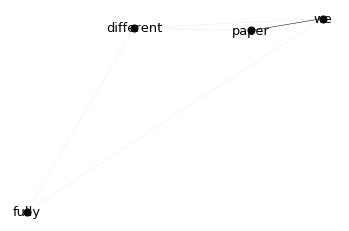

In [524]:
import matplotlib.pyplot as plt

options = {
    "node_color": "black",
    "node_size": 50,
    "linewidths": 0,
    "width": 0.1,
}

PMI_Threshold = 3
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= PMI_Threshold]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < PMI_Threshold]

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="black")

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=.5, linewidth=0)
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=.1, linewidth=0, alpha=0.5, style="dashed")
nx.draw_networkx_labels(G, pos, font_size=13, font_family="sans-serif")
# nx.draw_networkx(G, **options)
plt.axis("off")
plt.show()
# G.clear()

In [ ]:
df.select("extracted").write.mode("overwrite").csv("./extracted.csv", header=True)

In [89]:
sample = df.distinct().count()

In [ ]:
# df = df.repartition(100000)
print(df.rdd.getNumPartitions())

In [ ]:
df.select("extracted").write.mode("overwrite").csv("./extracted.csv", header=False)

In [ ]:
from pyspark.sql.functions import regexp_extract, col, concat, lit, when
from collections import Counter
from collections import defaultdict

corpus, co_occurence, documents = Counter(), Counter(), defaultdict(set)
df = abstracts.withColumn('extracted_words', regexp_extract('normalized', keywords_list[0], 0))

keywords_list2 = ["a", "describe", "paper", "algorithm"]

for i, keyword in enumerate(keywords_list[1:10],1):
    print("Working on {}".format(i))
#     df_temp = abstracts.withColumn('extracted_temp', regexp_extract('normalized', keywords_list[1], 0))
#     df = df_temp.withColumn('extracted_words2', concat(col('extracted_words'), lit(' '), col('extracted_temp')))
    df_temp = df.withColumn('extracted_temp', regexp_extract('normalized', keyword, 0))
    df = df_temp.withColumn('extracted_words', when(col('extracted_temp') != '', concat(col('extracted_words'), lit(",") ,col('extracted_temp'))).otherwise(col('extracted_words')))

#     df_temp3 = df_temp2.withColumn('extracted_temp', regexp_extract('normalized', "different", 0))
#     df_temp4 = df_temp3.withColumn('extracted_words', concat(col('extracted_words'), lit(' '), col('extracted_temp')))



    
    #     df = df.withColumn('joined_column', sf.concat(sf.col('colname1'),sf.lit('_'), sf.col('colname2')))
#     extracted_temp = list(df.select('extracted_words').toPandas()['extracted_words'])
    
    # update corpus, co_occurence, documents
#     doc_num = 0
#     for v in extracted_temp:
#         if not v:
#             continue
#         corpus[v] += 1
#         documents[doc_num].add(v)
#         doc_num += 1

In [ ]:
df.cache()

df.write.csv

In [ ]:
df.select('extracted_words').take(20)
# df.show()

In [ ]:
df_temp = df.withColumn('extracted_temp', regexp_extract('normalized', "fully", 0))
df_temp2 = df_temp.withColumn('extracted_words', concat(col('extracted_words'), lit(' '),col('extracted_temp')))

df_temp3 = df_temp2.withColumn('extracted_temp', regexp_extract('normalized', "different", 0))
df_temp4 = df_temp3.withColumn('extracted_words', concat(col('extracted_words'), lit(' '), col('extracted_temp')))




In [ ]:
l = keywords.collect()

In [ ]:
for n in l[:2]:
    print(n['normalizedName'])

In [ ]:
corpus

https://towardsdatascience.com/solving-combinatorial-problems-with-pyspark-fad433b1fca0

In [ ]:
from flashtext import KeywordProcessor

kp = KeywordProcessor()
keywords = ['abc']
for keyword in keywords:
    kp.add_keyword(keyword)

def extractKeywords(menu_name, kp=kp):
    keywords = kp.extract_keywords(menu_name)
    return ''.join(keywords)
    
extractKeywords_udf = udf(extractKeywords, StringType())

In [ ]:
df2 = df.withColumn("extracted_keyword", udf(abstracts["normalized"]))

### Testing partition

References
- running pyspark in jupyter
    - https://medium.com/@Vatsal410/running-pyspark-on-an-aws-cluster-through-jupyter-notebook-fe28f6ef47a4
- https://medium.com/@christo.lagali/run-jupyter-notebooks-with-pyspark-on-an-emr-cluster-9630ef54c4e1
- https://towardsdatascience.com/getting-started-with-pyspark-on-amazon-emr-c85154b6b921
- reading and writing s3
    - https://docs.cloudera.com/runtime/7.0.2/developing-spark-applications/topics/spark-examples-of-accessing-s3-data-from-spark.html
- textmining in apache spark
    - https://runawayhorse001.github.io/LearningApacheSpark/textmining.html
- https://medium.com/@serkansakinmaz/how-to-connect-amazon-s3-via-emr-based-pyspark-42707d540881

In [ ]:
l = [0,1,2,3,4,5,6,7,8,9]